# Detect overlapping between sources in cosmoDC2 and the object catalog

In [97]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Ellipse
from astropy.table import Table, join

import desc_dc2_dm_data

import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display.rgb as rgb
import pandas as pd

from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval

# define the object and the truth catalogs

In [98]:
from GCR import GCRQuery
from GCRCatalogs.dc2_truth_match import _flux_to_mag as flux_to_mag
import GCRCatalogs
import fitsio

In [6]:
if 0:
    
    object_cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons')
   
    ## filters for the object catalog
    cuts = [
        GCRQuery((np.isfinite, 'mag_i')), # Select objects that have i-band magnitudes
        GCRQuery('clean'),            # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                                      # and was not skipped by the deblender
        GCRQuery('mag_i_cModel < 24.5')  # cModel imag brighter than 24.5
    ]
    
    # Load ra and dec from object, using both of the filters we just defined.
    object_data = object_cat.get_quantities(['ra', 'dec', 'x', 'y', 'extendedness', \
                                             'Ixx_pixel', 'Iyy_pixel', 'Ixy_pixel', \
                                          'mag_i_cModel', 'mag_r_cModel', \
                                         'photoz_mode', 'blendedness', 'tract', 'patch'],
                                        filters=cuts, native_filters=['tract == 3447'])
    
    obj_all = pd.DataFrame(object_data)
    obj_all['obj_id'] = [i for i in range(len(obj_all))]
    obj_all.to_pickle('obj_tract_3447.pkl')
    
else:
    
    obj_all = pd.read_pickle('obj_tract_3447.pkl')
    obj_all = Table.from_pandas(obj_all)

## Only use objects from the Patches covered by truth catalog

In [7]:
mask = np.zeros(len(obj_all), dtype=bool)

for i in ['0', '1', '2', '3', '4']:
    pat = f'0,{i}'              
    mask = mask | (obj_all['patch'] == pat)
    
for i in ['0', '1', '2', '3']:
    pat = f'1,{i}'              
    mask = mask | (obj_all['patch'] == pat)
    
for i in ['0', '1', '2']:
    pat = f'2,{i}'              
    mask = mask | (obj_all['patch'] == pat)

mask = mask | (obj_all['patch'] == '3,0')

obj = obj_all[mask]

In [8]:
if 0:
    
    truth_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
    stars_cat = GCRCatalogs.load_catalog("dc2_truth_run2.2i_star_truth_summary")
    
    #stars_cat.list_all_quantities()
    
    if not stars_cat.has_quantity("mag_i"):
        stars_cat.add_derived_quantity("mag_i", flux_to_mag, "flux_i")
    
    if not stars_cat.has_quantity("mag_r"):
        stars_cat.add_derived_quantity("mag_r", flux_to_mag, "flux_r")

    min_ra = obj['ra'].min()
    max_ra = obj['ra'].max()
    min_dec = obj['dec'].min()
    max_dec = obj['dec'].max()

    pos_filters = [f'ra >= {min_ra}',f'ra <={max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']
    

    filters = pos_filters + ['mag_i < 26.5' ]

    truth_gals = truth_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'mag_i', 'mag_r', 'redshift',\
                                           'size_true', 'size_minor_true', 'position_angle_true',
                                           'halo_id', 'halo_mass'], filters=filters)
    truth_gals = pd.DataFrame(truth_gals)
    
    truth_gals["star"] = False
    truth_gals = truth_gals.rename(columns={"galaxy_id": "id"})
    
    
    
    truth_stars = stars_cat.get_quantities(['id', 'ra', 'dec', 'mag_i', 'mag_r', 'redshift'], filters=filters)
    truth_stars = pd.DataFrame(truth_stars)
    
    for col in ['size_true', 'size_minor_true', 'position_angle_true','halo_id', 'halo_mass']:
        truth_stars[col] = 0
    
    truth_stars["star"] = True
    truth_stars["id"] = truth_stars["id"].astype(np.int64)

    truth = pd.concat([truth_gals, truth_stars], ignore_index=True)
    
    truth.to_pickle('truth_tract_3447.pkl')
    
else:
    
    truth = pd.read_pickle('truth_tract_3447.pkl')
    truth = Table.from_pandas(truth)

## Footprint of the example source catalog; 

340095
63821


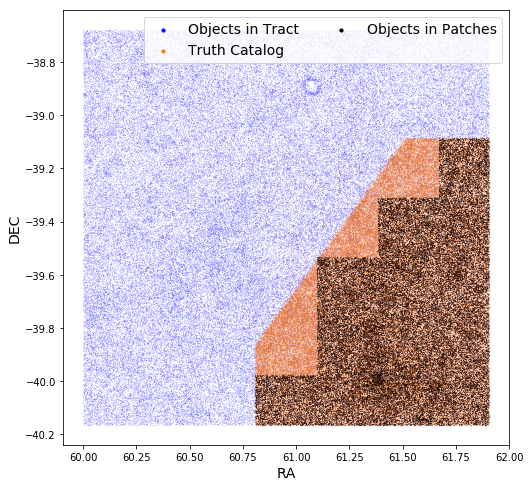

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.scatter(obj_all['ra'], obj_all['dec'], c='b', s=0.001, label='')
ax.scatter(truth['ra'], truth['dec'], c='C1', s=0.001, label='')
ax.scatter(obj['ra'], obj['dec'], c='k', s=0.01, label='')

ax.scatter([], [], c='b', s=10, label='Objects in Tract')
ax.scatter([], [], c='C1', s=10, label='Truth Catalog')
ax.scatter([], [], c='k', s=10, label='Objects in Patches')

ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('DEC', fontsize=14)
ax.legend(prop={'size':14}, ncol=2)

print(len(truth))
print(len(obj))

# The Ellipse Equation: 
## (https://en.wikipedia.org/wiki/Ellipse#General_ellipse , but swapping B and C)

$$
A x^2 + B y^2 + C x y +  D x +  E y + F = 0
$$
where 

$$
\begin{align}
A & = a^2\sin^2{\theta} +  b^2\cos^2{\theta},  \\
B & = a^2\cos^2{\theta} +  b^2\sin^2{\theta}, \\
C & = 2(b^2 - a^2)\sin{\theta}\cos{\theta}, \\
D & = -2Ax_0 - Cy_0,  \\
E & = -C x_0 - 2B y_0,  \\
F & = Ax_0^2 + C x_0 y_0 + By_0^2 - a^2 b^2. 
\end{align}
$$

$x_0, y_0$ are the coordinates for the ellipse center, $a$, $b$ the semi-major/minor axis and $\theta$ the position angle (the angle between the major axis and ra for the extragalactic catalog, and between the major axis and CCD x axis for the object catalog).

### following the definitions of https://www.sciencedirect.com/science/article/abs/pii/S0167839617300791 (hereafter AC2017):  
shrink the parameters CDE by half,

$$ C = C / 2, \quad D = D / 2, \quad E = E / 2, $$

and modify the Ellipse Equation:

$$
A x^2 + B y^2 + 2C x y + 2 D x + 2 E y + F = 0.
$$




In [10]:
def ellipse_equation(x, y, params):
    
    A, B, C, D, E, F = params
    
    return A*x**2 + B*y**2 + 2*C*x*y + 2*D*x + 2*E*y + F

def ab2AB(a, b, theta, x0, y0):
    
    ### a, b, in any length units; theta in degrees ###
    sin = np.sin(np.radians(theta))
    cos = np.cos(np.radians(theta))
    
    A = (a*sin)**2 + (b*cos)**2
    B = (a*cos)**2 + (b*sin)**2
    C = 2*(b**2 - a**2)*sin*cos
    D = -2*A*x0 - C*y0
    E = -C*x0 - 2*B*y0
    F = A*x0**2 + C*x0*y0 + B*y0**2 - (a*b)**2
    C, D, E = C/2, D/2, E/2
    
    return [A, B, C, D, E, F]

## The function is_overlapping provides a linear algorithm to detect overlapping ellipses, following AC2017.

In [11]:
def is_overlapping(ell_params1, ell_params2, sky=False):
    
    a1, b1, theta1, x1, y1 = ell_params1
    a2, b2, theta2, x2, y2 = ell_params2
    
    ## radec in degrees; move ra to ~180 to avoid periodic boundary at 360
    
    if sky==True:
        p1 = ab2AB(a1, b1, theta1, 0, y1)
        p2 = ab2AB(a2, b2, theta2, x2-x1, y2)
    else:
        p1 = ab2AB(a1, b1, theta1, x1, y1)
        p2 = ab2AB(a2, b2, theta2, x2, y2)
    
    A1, B1, C1, D1, E1, F1 = p1
    A2, B2, C2, D2, E2, F2 = p2
        
    M1 = [[A1, C1, D1], [C1, B1, E1], [D1, E1, F1]]
    M2 = [[A2, C2, D2], [C2, B2, E2], [D2, E2, F2]]
    
    l0 = np.linalg.det(M2)
    l1 = (np.linalg.det([[A1,C2,D2],[C1,B2,E2],[D1,E2,F2]]) +
            np.linalg.det([[A2,C1,D2],[C2,B1,E2],[D2,E1,F2]]) +
            np.linalg.det([[A2,C2,D1],[C2,B2,E1],[D2,E2,F1]])) / 3
    l2 = (np.linalg.det([[A2,C1,D1],[C2,B1,E1],[D2,E1,F1]]) +
            np.linalg.det([[A1,C2,D1],[C1,B2,E1],[D1,E2,F1]]) +
            np.linalg.det([[A1,C1,D2],[C1,B1,E2],[D1,E1,F2]])) / 3
    l3 = np.linalg.det(M1)

    delta1 = np.linalg.det([[l3, l2],[l2, l1]])
    delta2 = np.linalg.det([[l3, l1],[l2, l0]])
    delta3 = np.linalg.det([[l2, l1],[l1, l0]])
    discriminant_P = np.linalg.det([[2*delta1, delta2], [delta2, 2*delta3]])
    
    if (discriminant_P >=0) and ((l1>0) or (l2>0)):
        return False  ## not over-lapping
    else:
        return True

# To get the Ellipse parameters ABCDEF from the Object Catalog:
based on my calculation, for perfect ellipses with **constant-disk flux distribution:**
$$ 
\begin{align}
I_{xx} & = \frac{\pi}{4}ab \left( a^2\cos^2{\theta} + b^2\sin^2{\theta} \right), \\
I_{yy} & = \frac{\pi}{4}ab \left( a^2\sin^2{\theta} + b^2\cos^2{\theta} \right), \\ 
I_{xy} & = \frac{\pi}{4}ab \left( a^2 - b^2 \right) \cos{\theta}\sin{\theta}.
\end{align}
$$
therefore,
$$ 
\begin{align}
I_{xx}I_{yy} - I^2_{xy} 
    & = \frac{\pi^2}{16}a^2 b^2 
    \left[ \left( a^2\cos^2{\theta} + b^2\sin^2{\theta} \right) 
    \left( a^2\sin^2{\theta} + b^2\cos^2{\theta} \right) -
    \left( a^2 - b^2 \right)^2 \cos^2{\theta}\sin^2{\theta} \right] \\
    & = \frac{\pi^2}{16}a^4 b^4
\end{align}
$$
or

$$ \pi ab = 2\sqrt{\pi} \left( I_{xx}I_{yy} - I^2_{xy} \right)^{1/4}. $$

Furthermore, 

$$
\begin{align}
A & = a^2\sin^2{\theta} +  b^2\cos^2{\theta} = \frac{4I_{yy}}{\pi ab},  \\
B & = a^2\cos^2{\theta} +  b^2\sin^2{\theta} = \frac{4I_{xx}}{\pi ab}, \\
C & = 2(b^2 - a^2)\sin{\theta}\cos{\theta} = \frac{-8I_{xy}}{\pi ab}, \\ 
\end{align}
$$

and D, E, F follows.


Alternatively, calculate a, b, $\theta$ from the second moments first:
$$
\begin{align}
       \tan{2\theta} & = \frac{2 I_{xy}}{I_{xx} - I_{yy}}, \\
       a^2 & = \frac{4(I_{xx}\cos^2{\theta} - I_{yy}\sin^2{\theta})}{\pi ab \cos{2\theta}}, \\
       b^2 & = \frac{4(I_{yy}\cos^2{\theta} - I_{xx}\sin^2{\theta})}{\pi ab \cos{2\theta}}.
\end{align}
$$

In [12]:
def moments2AB(Ixx, Iyy, Ixy, x0, y0):
    
    ### Ixx, Iyy, Ixy in same unit as (x0, y0) ###
   
    pi_ab = 2 * np.sqrt(np.pi) * np.power(Ixx*Iyy - Ixy**2, 1/4)

    A = 4*Iyy/pi_ab
    B = 4*Ixx/pi_ab
    C = -8*Ixy/pi_ab

    D = -2*A*x0 - C*y0
    E = -C*x0 - 2*B*y0

    F = A*x0**2 + C*x0*y0 + B*y0**2 - (pi_ab/np.pi)**2
    C, D, E = C/2, D/2, E/2
    
    return [A, B, C, D, E, F]


def moments2ab(Ixx, Iyy, Ixy):
    
    ### Ixx, Iyy, Ixy in same unit as (x0, y0) ###
   
    pi_ab = 2 * np.sqrt(np.pi) * np.power(Ixx*Iyy - Ixy**2, 1/4)
    
    theta2 = np.arctan2(2*Ixy, Ixx-Iyy)
    theta2[theta2<0] += 2*np.pi
    
    theta = theta2 / 2
    
    sin = np.sin(theta)
    cos = np.cos(theta)
    cos2t = cos**2 - sin**2
    
    a_square = 4*(Ixx*cos**2 - Iyy*sin**2) / (pi_ab * cos2t)
    b_square = 4*(Iyy*cos**2 - Ixx*sin**2) / (pi_ab * cos2t)
    
    return [np.sqrt(a_square), np.sqrt(b_square), np.degrees(theta)]


#### verify the pixel scale (it's 0.2''/pix from https://arxiv.org/pdf/2010.05926.pdf)

In [10]:
N = len(obj)
i = np.random.randint(0, high=N)
j = np.random.randint(0, high=N)
print('pixel scale caculated from pair sources:', (i, j))

x1, y1 = obj['x'][i], obj['y'][i]
x2, y2 = obj['x'][j], obj['y'][j]
dist_pixel = np.sqrt( (x1-x2)**2 + (y1-y2)**2 )

ra1, dec1 = np.radians(obj['ra'][i]), np.radians(obj['dec'][i])
ra2, dec2 = np.radians(obj['ra'][j]), np.radians(obj['dec'][j])

cos_dist = np.sin(dec1)*np.sin(dec2) + np.cos(dec1)*np.cos(dec2)*np.cos(ra1-ra2)
dist_rad = np.arccos(cos_dist)
dist_arcsec = np.degrees(dist_rad)*3600

pixel_ratio = dist_arcsec / dist_pixel
print('pixel scale:', pixel_ratio, 'arcsec/pix')

pixel scale caculated from pair sources: (7821, 59796)
pixel scale: 0.19998488084622415 arcsec/pix


## calculate ellipse parameters for each object; everything in pixel coordinates

In [14]:
x0 = obj['x']
y0 = obj['y']

Ixx = obj['Ixx_pixel']
Iyy = obj['Iyy_pixel']
Ixy = obj['Ixy_pixel']

## 'o' for 'object'


obj['a_obj'], obj['b_obj'], obj['theta_obj'] = moments2ab(Ixx, Iyy, Ixy)
obj['pi_ab'] = np.pi * obj['a_obj'] * obj['b_obj']

obj['Ao'], obj['Bo'], obj['Co'], obj['Do'], obj['Eo'], obj['Fo'] = ab2AB(obj['a_obj'], obj['b_obj'], obj['theta_obj'], x0, y0)
obj['Ao'], obj['Bo'], obj['Co'], obj['Do'], obj['Eo'], obj['Fo'] = moments2AB(Ixx, Iyy, Ixy, x0, y0)


## Fudge factor of n**4 to make ellipses n times bigger
## 'f' for fudge
n = 1.5
fud = n**4

obj['Aof'], obj['Bof'], obj['Cof'], obj['Dof'], obj['Eof'], obj['Fof'] = ab2AB(n*obj['a_obj'], n*obj['b_obj'], obj['theta_obj'], x0, y0)
obj['Aof'], obj['Bof'], obj['Cof'], obj['Dof'], obj['Eof'], obj['Fof'] = moments2AB(fud*Ixx, fud*Iyy, fud*Ixy, x0, y0)


/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


## also calculate ellipse parameters in sky coordinates

In [99]:
ra = obj['ra']
dec = obj['dec']

#Ixx_s = obj['Ixx_pixel'] * (0.2 / 3600.)**4    ## in deg^4
#Iyy_s = obj['Iyy_pixel'] * (0.2 / 3600.)**4    ## in deg^4
#Ixy_s = obj['Ixy_pixel'] * (0.2 / 3600.)**4    ## in deg^4

obj['as_obj'] = obj['a_obj'] * (0.2 / 3600.)           ## in deg
obj['bs_obj'] = obj['b_obj'] * (0.2 / 3600.)           ## in deg
obj['pi_abs'] =  obj['pi_ab'] * (0.2 / 3600.)**2

## s for sky coordinates
## f for fudge
obj['Aos'], obj['Bos'], obj['Cos'], obj['Dos'], obj['Eos'], obj['Fos'] = ab2AB(obj['as_obj'], obj['bs_obj'], 180-obj['theta_obj'], ra, dec)
obj['Aosf'], obj['Bosf'], obj['Cosf'], obj['Dosf'], obj['Eosf'], obj['Fosf'] = ab2AB(n*obj['as_obj'], n*obj['bs_obj'], 180-obj['theta_obj'], ra, dec)



## Plot detected shape of some sources

In [13]:
def plot_shape(x0, y0, rough_size, params, c='b', ls='-', ax=None):
    
    x = np.linspace(x0 - rough_size, x0 + rough_size, 100)
    y = np.linspace(y0 - rough_size, y0 + rough_size, 100)
    x, y = np.meshgrid(x,y)
 
    z = ellipse_equation(x, y, params)
    
    ax.contour(x, y, z, [0], colors=c, linestyles=ls) 

In [14]:
pat = '2,2'
obj_patch = obj[ obj['patch'] == pat ]

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([552., 533., 558., 515., 583., 544., 582., 550., 609., 606.]),
 array([5.19066903e-03, 1.79979831e+01, 3.59907756e+01, 5.39835681e+01,
        7.19763606e+01, 8.99691530e+01, 1.07961946e+02, 1.25954738e+02,
        1.43947530e+02, 1.61940323e+02, 1.79933115e+02]),
 <a list of 10 Patch objects>)

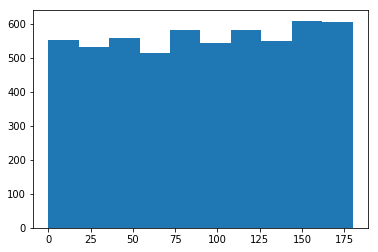

In [15]:
plt.hist(obj_patch['theta_obj'])

29.24738202637083


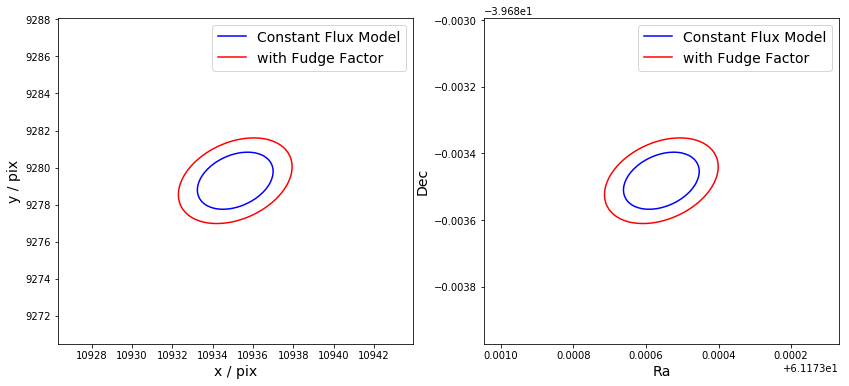

In [16]:
N = len(obj_patch)

x0 = obj_patch['x']
y0 = obj_patch['y']

ra = obj_patch['ra']
dec = obj_patch['dec']

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in np.random.randint(0, high=N, size=1):
    
    print(obj_patch['theta_obj'][i])
    ######## in pixel coordinates ############
    rough_size = 3*np.sqrt(obj_patch['pi_ab'][i] )
    
    params = [obj_patch[f'{X}o'][i] for X in ['A', 'B', 'C', 'D', 'E','F'] ]
    plot_shape( x0[i], y0[i], rough_size, params, c='b', ls='-', ax=ax1)
    
    
    params = [obj_patch[f'{X}of'][i] for X in ['A', 'B', 'C', 'D', 'E','F'] ]
    plot_shape( x0[i], y0[i], rough_size, params, c='r', ls='-', ax=ax1)

    ax1.set_xlabel('x / pix', fontsize=14)
    ax1.set_ylabel('y / pix', fontsize=14)
    
    
    ######## in sky coordinates ###############
    rough_size = 3*np.sqrt( obj_patch['pi_abs'][i] )
    
    params = [obj_patch[f'{X}os'][i] for X in ['A', 'B', 'C', 'D', 'E','F'] ]
    plot_shape( ra[i], dec[i], rough_size, params, c='b', ls='-', ax=ax2)
    
    params = [obj_patch[f'{X}osf'][i] for X in ['A', 'B', 'C', 'D', 'E','F'] ]
    plot_shape( ra[i], dec[i], rough_size, params, c='r', ls='-', ax=ax2)
    
    ax2.set_xlabel('Ra', fontsize=14)
    ax2.set_ylabel('Dec', fontsize=14)
   
    ax2.invert_xaxis()
    
    for ax in [ax1, ax2]:
        
        ax.plot([], [], 'b', label='Constant Flux Model')
        ax.plot([], [], 'r', label='with Fudge Factor')
    
        ax.legend(prop={'size':14})
        

# Overlay on Images

In [17]:
sorted(desc_dc2_dm_data.REPOS)

['1.1p',
 '1.2i',
 '1.2p',
 '1.2p_v3',
 '1.2p_v4',
 '2.1i',
 '2.1i_dr1a',
 '2.1i_dr1b',
 '2.1i_dr4',
 '2.1i_v1',
 '2.2i_dia_y2_t3828',
 '2.2i_dr2',
 '2.2i_dr2_tract3828',
 '2.2i_dr2_wfd',
 '2.2i_dr3',
 '2.2i_dr6',
 '2.2i_dr6_v1',
 '2.2i_dr6_wfd',
 'dia_2020Jan']

## Find tract and patch for objects

In [18]:
dc2_data_version = "2.2i_dr6_wfd"
butler = desc_dc2_dm_data.get_butler(dc2_data_version)

skymap = butler.get('deepCoadd_skyMap')

object_this = obj_patch[0]
dataId = {"tract": object_this["tract"], "patch": object_this["patch"], "filter": "i"}
full_patch = butler.get("deepCoadd", dataId=dataId)

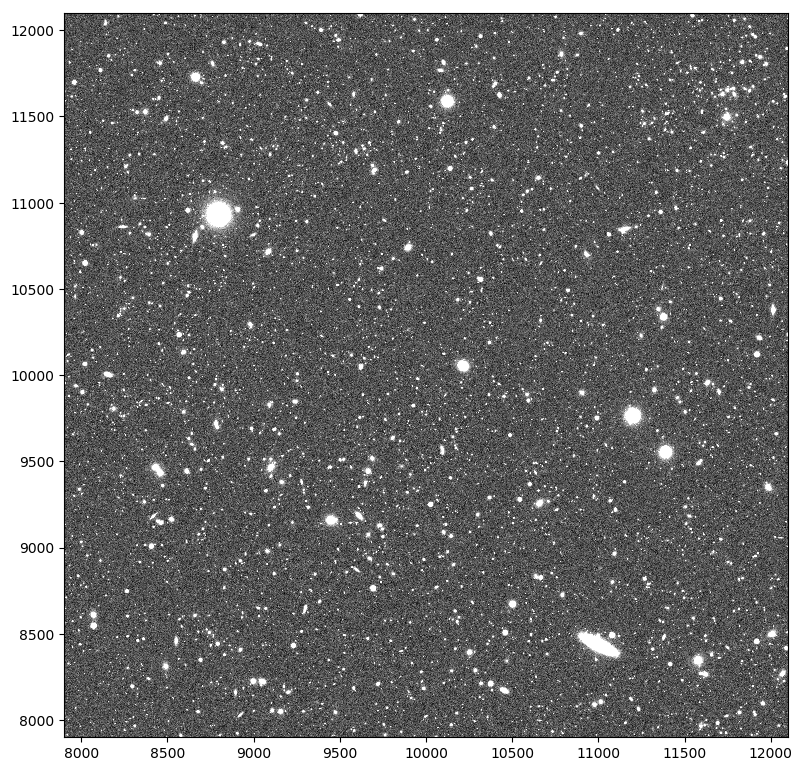

In [19]:
fig = plt.figure(figsize=(8, 8), dpi=100)
# Note that we set frame=1 below to allow afwDisplay to use the figure instance we created
display = afwDisplay.Display(1, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(full_patch.getMaskedImage().getImage())

879
9175.564011262282 8169.853006105827


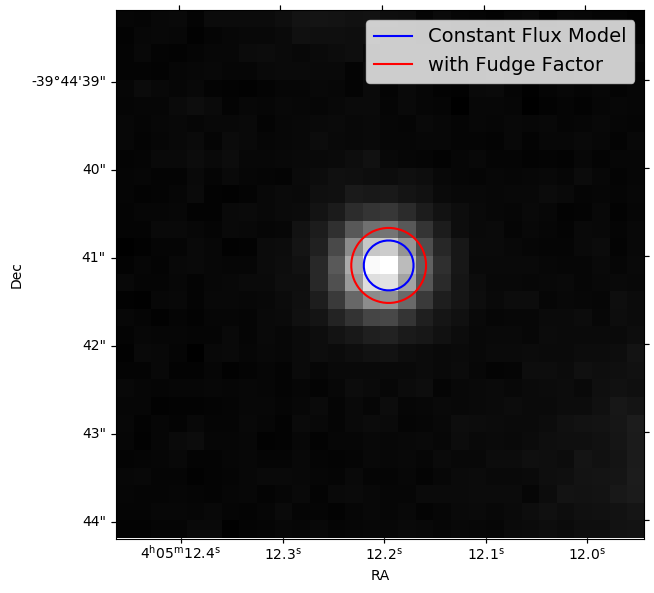

In [72]:
N = len(obj_patch)

cutout_size = 30  # 300 pixels -> about 1 arcmin; use even-number size!!
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

Ixx = obj_patch['Ixx_pixel']
Iyy = obj_patch['Iyy_pixel']
Ixy = obj_patch['Ixy_pixel']

fudge = 1.5**4

for i in np.random.randint(0, high=N, size=1):
#for i in [135, 558, 1294, 1476, 1845, 1858, 1875, 1881, 2008, 505, 558]:
#for i in [345]:
    
    print(i)
    radec = lsst.geom.SpherePoint(obj_patch["ra"][i], obj_patch["dec"][i], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    
    print(center.x, center.y)
    
    if np.floor(center.x) - np.round(center.x) == 0:
        pix_center_x = center.x
    else:
        pix_center_x = center.x + 1
        
    if np.floor(center.y) - np.round(center.y) == 0:
        pix_center_y = center.y
    else:
        pix_center_y = center.y + 1
    
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((pix_center_x - cutout_size*0.5, pix_center_y - cutout_size*0.5)), cutout_extent)

    cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)
    wcs = cutout.getWcs()

    off = lsst.geom.Extent2D(-(pix_center_x - cutout_size*0.5), -(pix_center_y - cutout_size*0.5))
    wcs_new = wcs.copyAtShiftedPixelOrigin(off)
    wcs_fits_meta = wcs_new.getFitsMetadata()
    
    image_arr = cutout.getMaskedImage().getImage().array
    #center_new = wcs_new.skyToPixel(radec)
    
    fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(7, 7), dpi=100)

    #vmin, vmax = ZScaleInterval().get_limits(image_arr)
    vmin, vmax = image_arr.min(), image_arr.max()
    
    ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
    
    rough_size = 2*np.sqrt( obj_patch['pi_ab'][i] )
    
    x = np.linspace(cutout_size/2-2*rough_size, cutout_size/2+2*rough_size, 100)
    y = np.linspace(cutout_size/2-2*rough_size, cutout_size/2+2*rough_size, 100)
    x, y = np.meshgrid(x,y)
    
    params = moments2AB(Ixx[i], Iyy[i], Ixy[i], cutout_size/2, cutout_size/2)
    z = ellipse_equation(x, y, params)
    
    params = moments2AB(fudge*Ixx[i], fudge*Iyy[i], fudge*Ixy[i], cutout_size/2, cutout_size/2)
    ze = ellipse_equation(x, y, params)
    
    ax.contour(x, y, z, [0], zorder=10, colors='blue')    ## constan-flux-model size
    ax.contour(x, y, ze, [0], zorder=10, colors='red')    ## fudged size
    
    ax.plot([], [], 'b', label='Constant Flux Model')
    ax.plot([], [], 'r', label='with Fudge Factor')
    
    #ax.scatter(cutout_size/2, cutout_size/2, s=10, label='Image Center +1')
    #ax.scatter(center_new[0], center_new[1], s=10, label='Image Center From Sky')
    
    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    
    ax.legend(prop={'size':14})
    
    #plt.savefig(f'./obj/{i}.jpeg')
    #plt.cla()

## check the wcs on objects

In [21]:
ra = obj_patch['ra']
dec = obj_patch['dec']

N = len(obj_patch)
print(N)

5637


In [22]:
for j in np.random.randint(0, high=N, size=1):
    radec = lsst.geom.SpherePoint(ra[j], dec[j], lsst.geom.degrees)
    wcs = skymap.findTract(radec).getWcs()
    print(j, wcs.getCdMatrix())

263 [[-5.55555556e-05  0.00000000e+00]
 [ 0.00000000e+00  5.55555556e-05]]


In [23]:
3600*(-5.5555555e-5)

-0.19999999799999998

In [24]:
x_from_sky = np.zeros(N)
y_from_sky = np.zeros(N)

for i, (ra_this, dec_this) in enumerate(zip(ra, dec)):
    radec = lsst.geom.SpherePoint(ra_this, dec_this, lsst.geom.degrees)
    x_from_sky[i], y_from_sky[i] = wcs.skyToPixel(radec)

obj_patch['x_from_sky'] = x_from_sky
obj_patch['y_from_sky'] = y_from_sky

In [25]:
d = np.sqrt( (obj_patch['x'] - obj_patch['x_from_sky'])**2 + (obj_patch['y'] - obj_patch['y_from_sky'])**2)

In [26]:
d.max()

5.941054419030574e-10

# measure the PSF by looking at stars
## (to convole with the sizes of truth catalog)

for stars of constant flux within radius $r$, 

$$a=b=r,$$ 

and 

$$I_{xx} = I_{yy} = \frac{\pi}{4}r^4,$$ 

so 

$$ r = \left( \frac{2(I_{xx} + I_{yy})}{\pi} \right)^{1/4}. $$

for stars of Gaussian disk with width $\sigma$, 

$$\sigma^2 = I_{xx} = I_{yy},$$

or 

$$\sigma = \sqrt{ ( I_{xx} +  I_{yy}) / 2 },$$

and

$$ FWHM = \sqrt{\ln{4}} \cdot \sigma = 1.1774 \sigma.$$

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


0.00011592377391205649


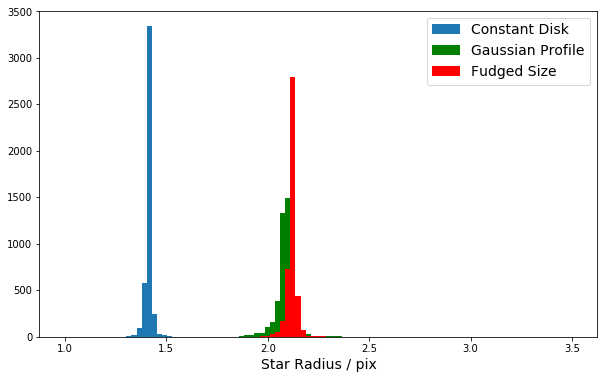

In [27]:
stars = obj[ (obj['extendedness'] == 0 )]

Ixx = stars['Ixx_pixel'] ## in pixels
Iyy = stars['Iyy_pixel'] ## in pixels

stars['r'] = np.power(2*(Ixx + Iyy)/np.pi, 1/4)
stars['r_gauss' ] = 1.17741002252* np.power((Ixx + Iyy)/2, 1/2)
stars['r_fudge'] = 1.5 * stars['r'] ## fudge factor for the constant-flux disk model; see below


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.hist(stars['r'], bins=np.linspace(1,3.5,100), label='Constant Disk')
ax.hist(stars['r_gauss'], bins=np.linspace(1,3.5,100), color='g', label='Gaussian Profile')
ax.hist(stars['r_fudge'], bins=np.linspace(1,3.5,100), color='r', label='Fudged Size')

ax.set_xlabel('Star Radius / pix', fontsize=14)
ax.legend(prop={'size':14})

psf = np.median(stars['r_gauss']) * 0.2 / 3600    ## in degree; pixel ratio is 0.2"/pix
print(psf)

In [28]:
stars = stars[ stars['patch'] == pat ]

207


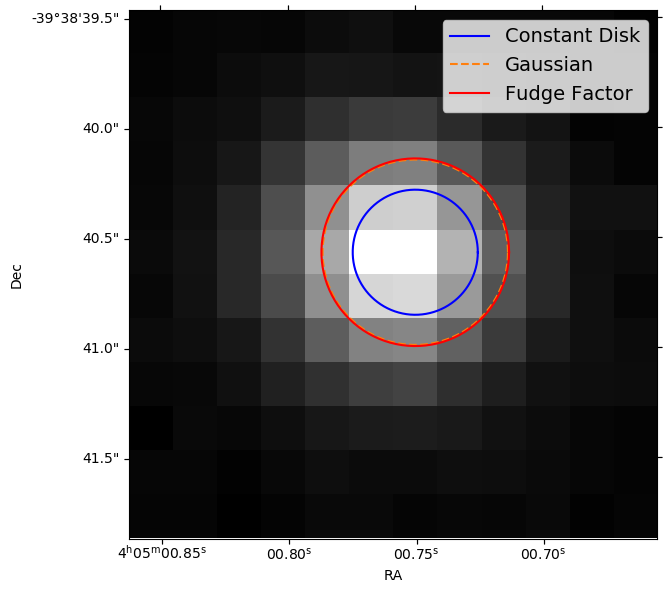

In [29]:

cutout_size = 12  # 300 pixels -> about 1 arcmin; use even-number size!!
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

theta = np.linspace(0, 2*np.pi, 100)
x = np.cos(theta)
y = np.sin(theta)

N = len(stars)
for i in np.random.randint(0, high=N, size=1):

    print(i)

    radec = lsst.geom.SpherePoint(stars["ra"][i], stars["dec"][i], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    
    if np.floor(center.x) - np.round(center.x) == 0:
        pix_center_x = center.x
    else:
        pix_center_x = center.x + 1
        
    if np.floor(center.y) - np.round(center.y) == 0:
        pix_center_y = center.y
    else:
        pix_center_y = center.y + 1
    
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((pix_center_x - cutout_size*0.5, pix_center_y - cutout_size*0.5)), cutout_extent)
    
    cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)
    wcs = cutout.getWcs()

    #off = lsst.geom.Extent2D(-(center.x - cutout_size*0.5), -(center.y - cutout_size*0.5))
    off = lsst.geom.Extent2D(-(pix_center_x - cutout_size*0.5), -(pix_center_y - cutout_size*0.5))
    wcs_new = wcs.copyAtShiftedPixelOrigin(off)
    #center_new = wcs_new.skyToPixel(radec)
    
    wcs_fits_meta = wcs_new.getFitsMetadata()
    image_arr = cutout.getMaskedImage().getImage().array
    
    fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(7, 7), dpi=100)

    
    #vmin, vmax = ZScaleInterval().get_limits(image_arr)
    vmin, vmax = image_arr.min(), image_arr.max()
    ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
    
    ax.plot(cutout_size/2 + stars['r'][i]*x, cutout_size/2 + stars['r'][i]*y, 'b', label='Constant Disk')
    ax.plot(cutout_size/2 + stars['r_gauss'][i]*x, cutout_size/2 + stars['r_gauss'][i]*y, 'C1--', label='Gaussian')
    ax.plot(cutout_size/2 + stars['r_fudge'][i]*x, cutout_size/2 + stars['r_fudge'][i]*y, 'r', label='Fudge Factor')
    
    #ax.scatter(cutout_size/2, cutout_size/2, s=10, label='Image Center')
    #ax.scatter(center_new.x, center_new.y, s=10, label='Image Center From Sky')
    
    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    
    ax.legend(prop={'size':14})
    
    #plt.savefig(f'./stars/{i}.jpeg')
    #plt.cla()

# To get the Ellipse parameters ABCDEF from the truth catalog

In [30]:
truth = pd.read_pickle('truth_tract_3447.pkl')
truth = Table.from_pandas(truth)

In [31]:
ra = truth['ra']
dec = truth['dec']

N = len(truth)
x0 = np.zeros(N)
y0 = np.zeros(N)

for i, (ra_this, dec_this) in enumerate(zip(ra, dec)):
    radec = lsst.geom.SpherePoint(ra_this, dec_this, lsst.geom.degrees)
    x0[i], y0[i] = wcs.skyToPixel(radec)

truth['x0_t'] = x0
truth['y0_t'] = y0


In [32]:
for j in np.random.randint(0, high=N, size=1):
    radec = lsst.geom.SpherePoint(ra[j], dec[j], lsst.geom.degrees)
    wcs = skymap.findTract(radec).getWcs()
    print(j)
    print(wcs)

12214
FITS standard SkyWcs:
Sky Origin: (60.952381, -39.421488)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel


In [33]:
ra = truth['ra']
dec = truth['dec']

a = truth['size_true'] / 3600.            ## arcsec to degree
b = truth['size_minor_true'] / 3600.      ## arcsec to degree

a_eff = np.sqrt( a**2 + psf**2)           ## in degree
b_eff = np.sqrt( b**2 + psf**2)           ## in degree

a_pix = truth['size_true'] / 0.2          ## pixel ratio is 0.2"/pix
b_pix = truth['size_minor_true'] / 0.2    ## pixel ratio is 0.2"/pix

a_pix_eff = a_eff * 3600 / 0.2            ## pixel ratio is 0.2"/pix
b_pix_eff = b_eff * 3600 / 0.2            ## pixel ratio is 0.2"/pix

truth['size_eff'] = a_eff * 3600          ## in arcsecs
truth['size_minor_eff'] = b_eff * 3600    ## in arcsecs

truth['size_pix'] = a_pix                 ## in pixels
truth['size_minor_pix'] = b_pix           ## in pixels

truth['size_pix_eff'] = a_pix_eff      
truth['size_minor_pix_eff'] = b_pix_eff

theta = 270 - truth['position_angle_true']
theta[theta>180] -= 180

## s for sky coordinates in degrees
truth['Ats'], truth['Bts'], truth['Cts'], truth['Dts'], truth['Ets'], truth['Fts'] = ab2AB(a_eff, b_eff, 180-theta, ra, dec)
truth['pi_abts'] = np.pi * a_eff * b_eff

## also calculate in pixel coordinates
truth['At'], truth['Bt'], truth['Ct'], truth['Dt'], truth['Et'], truth['Ft'] = ab2AB(a_pix_eff, b_pix_eff, theta, truth['x0_t'], truth['y0_t'])
truth['pi_abt'] = np.pi * a_pix_eff * b_pix_eff

truth['theta_true'] = theta

In [34]:
min_ra = obj_patch['ra'].min()
max_ra = obj_patch['ra'].max()
min_dec = obj_patch['dec'].min()
max_dec = obj_patch['dec'].max()
    
mask = (truth['ra'] >= min_ra) & (truth['ra'] <= max_ra) & (truth['dec'] >= min_dec) & (truth['dec'] <= max_dec) 

truth_patch = truth[ mask ]

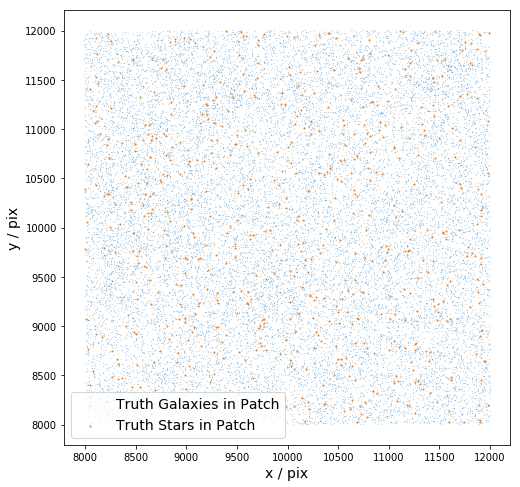

In [35]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.set_xlabel('x / pix', fontsize=14)
ax.set_ylabel('y / pix', fontsize=14)

ax.scatter(truth_patch['x0_t'], truth_patch['y0_t'], s=0.01, label='Truth Galaxies in Patch')
ax.scatter(truth_patch[truth_patch['star']]['x0_t'], truth_patch[truth_patch['star']]['y0_t'], s=1, label='Truth Stars in Patch') 

ax.legend(prop={'size':14})

## plot some sources

In [36]:
x0 = truth_patch['x0_t']
y0 = truth_patch['y0_t']

ra = truth_patch['ra']
dec = truth_patch['dec']

a = truth_patch['size_true']/3600
b = truth_patch['size_minor_true']/3600

a_eff = truth_patch['size_eff']/3600
b_eff = truth_patch['size_minor_eff']/3600

a_pix = truth_patch['size_pix']
b_pix = truth_patch['size_minor_pix']

a_pix_eff = truth_patch['size_pix_eff']
b_pix_eff = truth_patch['size_minor_pix_eff']

theta = truth_patch['theta_true']

position angle: 121.1832602060814


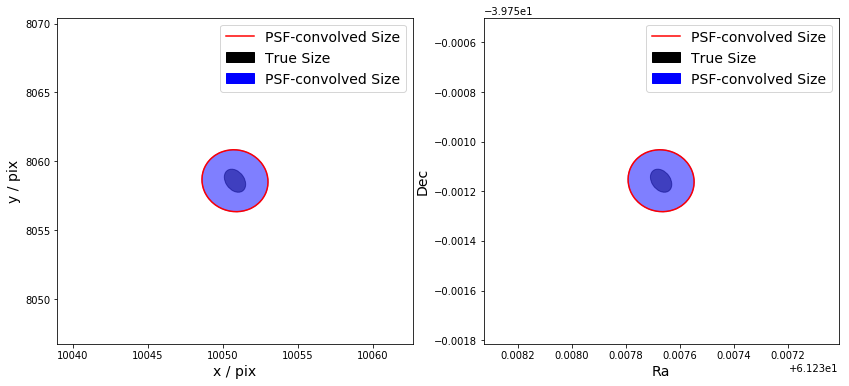

In [37]:
N = len(truth_patch)

fig = plt.figure(figsize=(14,6))

for i in np.random.randint(0, high=N, size=1):
    
    ########## set up coordinates ###########
    
    print('position angle:', truth_patch['theta_true'][i])
    
    ax1 = fig.add_subplot(121)
    
    radec = lsst.geom.SpherePoint(ra[i], dec[i], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    
    if np.floor(center.x) - np.round(center.x) == 0:
        pix_center_x = center.x
    else:
        pix_center_x = center.x + 1
        
    if np.floor(center.y) - np.round(center.y) == 0:
        pix_center_y = center.y
    else:
        pix_center_y = center.y + 1
    
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((pix_center_x - cutout_size*0.5, pix_center_y - cutout_size*0.5)), cutout_extent)
    cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)
    wcs = cutout.getWcs()

    off = lsst.geom.Extent2D(-(pix_center_x - cutout_size*0.5), -(pix_center_y - cutout_size*0.5))
    wcs_new = wcs.copyAtShiftedPixelOrigin(off)
    wcs_fits_meta = wcs_new.getFitsMetadata()
    
    #ax2 = fig.add_subplot(122, projection=WCS(wcs_fits_meta))
    ax2 = fig.add_subplot(122)
    
    ######## in pixel coordinates ############

    
    rough_size = 3*np.sqrt( truth_patch['pi_abt'][i] )
    
    params = [truth_patch[f'{X}t'][i] for X in ['A', 'B', 'C', 'D', 'E','F'] ]
    plot_shape( x0[i], y0[i], rough_size, params, c='r', ls='-', ax=ax1)
    
    ellipse = Ellipse((x0[i], y0[i]), width = 2*a_pix[i], height = 2*b_pix[i],\
                      angle = theta[i], color='k', alpha=0.5, linewidth=1)

    ax1.add_artist(ellipse)
    
    ellipse = Ellipse((x0[i], y0[i]), width = 2*a_pix_eff[i], height = 2*b_pix_eff[i], \
                      angle = theta[i], color='b', alpha=0.5, linewidth=1)

    ax1.add_artist(ellipse)
    
    ax1.set_xlabel('x / pix', fontsize=14)
    ax1.set_ylabel('y / pix', fontsize=14)
    
    ######## in sky coordinates ###############    
    
    rough_size = 3*np.sqrt( truth_patch['pi_abts'][i] )
    
    params = [truth_patch[f'{X}ts'][i] for X in ['A', 'B', 'C', 'D', 'E','F'] ]
    plot_shape( ra[i], dec[i], rough_size, params, c='r', ls='-', ax=ax2)

    ellipse = Ellipse((ra[i], dec[i]), width = 2*a[i], height = 2*b[i], \
                      angle = 180-theta[i], color='k', alpha=0.5, linewidth=1)

    ax2.add_artist(ellipse)
    
    ellipse = Ellipse((ra[i], dec[i]), \
                      width = 2*a_eff[i], height = 2*b_eff[i], \
                      angle = 180-theta[i], color='b', alpha=0.5, linewidth=1)

    ax2.add_artist(ellipse)
    
    ax2.set_xlabel('Ra', fontsize=14)
    ax2.set_ylabel('Dec', fontsize=14)

    ax2.invert_xaxis()
    
    for ax in [ax1, ax2]:

        ax.fill_between([], [], [], color='k', label='True Size')
        ax.fill_between([], [], [], color='b', label='PSF-convolved Size')
        ax.plot([], [], color='r', label='PSF-convolved Size')

        ax.legend(prop={'size':14})
        

### Match the two catalogs with KD tree (primary  match, only by position and magnitude)

In [38]:
from scipy import spatial

In [39]:
gals = obj[ obj['extendedness'] == 1 ]

In [40]:
coord1 = np.asarray([gals['ra'], gals['dec']])
coord2 = np.asarray([truth['ra'], truth['dec']])

## make tree with cat2 to search in cat2
kdt = spatial.cKDTree(coord2.T)

## search in tree the closest to objects
## idx, d2d has the same length of the object catalog
d2d, idx = kdt.query(coord1.T)

In [41]:
truth_match = truth[idx]
truth_match['obj_id'] = gals['obj_id']

In [42]:
## find distance cut
eps = 1.0/3600
rad_mask = d2d < eps

print('within radius / all closest:')
print(np.sum(rad_mask), '/', len(d2d), '=', np.sum(rad_mask)/len(d2d))

truth_match_dcut = truth_match[rad_mask]

#n, bins, patches = plt.hist(3600*d2d[rad_mask], bins='auto', label='within radius cut')
#plt.xlabel('distance between matched sources (arcsec)', fontsize=14)
#plt.show()

within radius / all closest:
58473 / 59268 = 0.9865863535128568


In [43]:
## find magnitude cut
obj_dcut = gals[rad_mask]
mag_diff =  obj_dcut['mag_i_cModel'] - truth_match_dcut['mag_i']
mag_mask = np.abs(mag_diff) < 2
                                
print('within mag_diff / all mag_diff:')
print(np.sum(mag_mask), '/', len(truth_match_dcut), '=', np.sum(mag_mask)/len(truth_match_dcut))

truth_match_dcut_mcut = truth_match_dcut[mag_mask]
                                
#n, bins, patches = plt.hist(list(mag_diff), bins='auto')
#plt.xlabel('mag i difference between matching', fontsize=14)
#plt.show()

within mag_diff / all mag_diff:
57374 / 58473 = 0.9812050005985669


In [44]:
truth_match_dcut_mcut.rename_column('ra', 'ra_true')
truth_match_dcut_mcut.rename_column('dec', 'dec_true')

In [45]:
match = join(gals, truth_match_dcut_mcut, keys='obj_id', join_type='left')

for col in truth_match_dcut_mcut.columns:
    match[col].fill_value = -1

match['PM_FLAG'] = True ## primary match flag
match['PM_FLAG'] *= (match['ra_true'].filled() > 0)
    
match.write('primary_match_tract_3447.fits', format='fits', overwrite=True)

## compare the shapes of a matched pair

In [46]:
pair = match[ match['PM_FLAG'] ]

diff = pair['theta_true'] - pair['theta_obj']

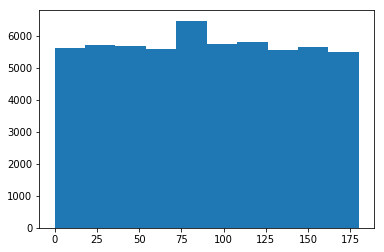

In [47]:
hist = plt.hist(pair['theta_true'])

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


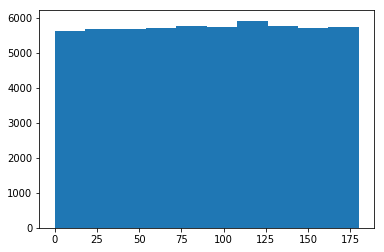

In [48]:
hist = plt.hist(pair['theta_obj'])

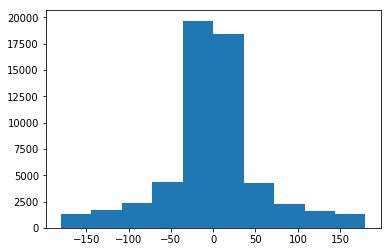

In [49]:
hist = plt.hist(diff)

In [75]:
ra = pair['ra']
dec = pair['dec']

x0 = pair['x']
y0 = pair['y']

position angle truth: 80.65947074790233
position angle detection: 106.27995650038713


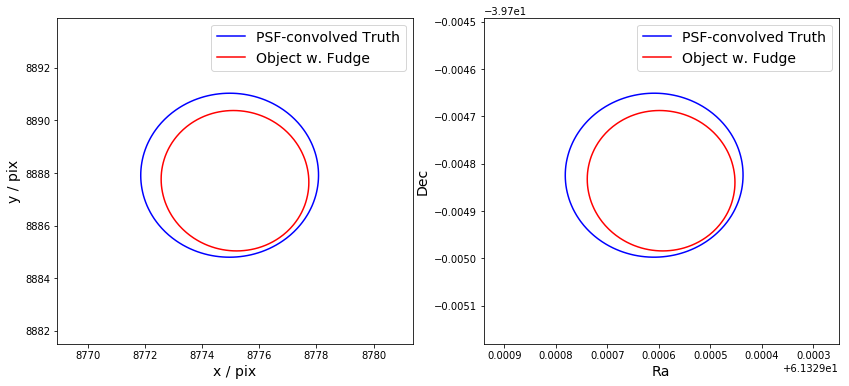

In [78]:
N = len(pair)

fig = plt.figure(figsize=(14,6))


for i in np.random.randint(0, high=N, size=1):
    
    print('position angle truth:', pair['theta_true'][i])
    print('position angle detection:', pair['theta_obj'][i])

    
    ax1 = fig.add_subplot(121)
    
    radec = lsst.geom.SpherePoint(ra[i], dec[i], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    
    #ax2 = fig.add_subplot(122, projection=WCS(wcs_fits_meta))
    ax2 = fig.add_subplot(122)

    ######## pixels coordinates ##########
    
    rough_size = 2 * np.sqrt( pair['pi_ab'][i] )
    
    #params_obj = [pair[f'{X}o'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    #plot_shape( x0[i], y0[i], rough_size, params_obj, c='r', ls='--', ax=ax1)
    
    params_obj_fud = [pair[f'{X}of'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    plot_shape( x0[i], y0[i], rough_size, params_obj_fud, c='r', ls='-', ax=ax1)
    
    params_truth = [pair[f'{X}t'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    plot_shape( x0[i], y0[i], rough_size, params_truth, c='b', ls='-', ax=ax1)

    ax1.set_xlabel('x / pix', fontsize=14)
    ax1.set_ylabel('y / pix', fontsize=14)
    
    ######## sky coordinates #######
    
    rough_size = 2 * np.sqrt( pair['pi_abs'][i] )
    
    #params_obj = [pair[f'{X}os'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    #plot_shape( ra[i], dec[i], rough_size, params_obj, c='r', ls='--', ax=ax2)
    
    params_obj_fud = [pair[f'{X}osf'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    plot_shape( ra[i], dec[i], rough_size, params_obj_fud, c='r', ls='-', ax=ax2)
    
    params_truth = [pair[f'{X}ts'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    plot_shape( ra[i], dec[i], rough_size, params_truth, c='b', ls='-', ax=ax2)

    ax2.set_xlabel('Ra', fontsize=14)
    ax2.set_ylabel('Dec', fontsize=14)
    
    ax2.invert_xaxis()

    for ax in [ax1, ax2]:
        
        ax.plot([], [], 'b-', label='PSF-convolved Truth')
        #ax.plot([], [], 'r--', label='Object')
        ax.plot([], [], 'r-', label='Object w. Fudge')
        
        ax.legend(prop={'size':14})

    #plt.savefig(f'primary/{i}.jpeg')
    #plt.cla()

### some problem galaxies: i = 3323,423 for pair=pair[pat]

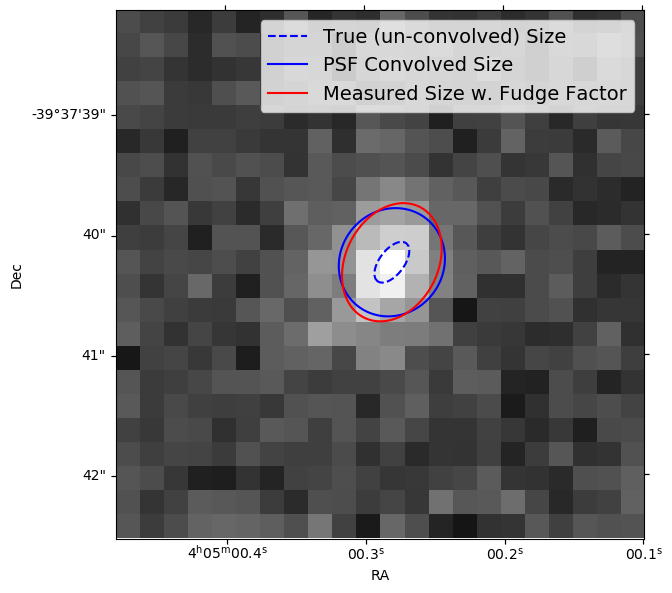

In [52]:
pair = pair[ pair['patch'] == pat ]
N = len(pair)

cutout_size = 22 # 300 pixels -> about 1 arcmin (we'll see why in a bit!)
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

a_pix = pair['size_pix']
b_pix = pair['size_minor_pix']

a_pix_eff = pair['size_pix_eff']
b_pix_eff = pair['size_minor_pix_eff']

n = 1.5

for i in np.random.randint(0, high=N, size=1):
#for i in [135, 558, 1294, 1476, 1845, 1858, 1875, 1881, 2008, 505]:
    
    radec = lsst.geom.SpherePoint(pair["ra"][i], pair["dec"][i], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    
    if np.floor(center.x) - np.round(center.x) == 0:
        pix_center_x = center.x
    else:
        pix_center_x = center.x + 1
        
    if np.floor(center.y) - np.round(center.y) == 0:
        pix_center_y = center.y
    else:
        pix_center_y = center.y + 1
        
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((pix_center_x - cutout_size*0.5, pix_center_y - cutout_size*0.5)), cutout_extent)

    cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)
    wcs = cutout.getWcs()

    off = lsst.geom.Extent2D(-(pix_center_x - cutout_size*0.5), -(pix_center_y - cutout_size*0.5))
    wcs_new = wcs.copyAtShiftedPixelOrigin(off)
    wcs_fits_meta = wcs_new.getFitsMetadata()
    
    image_arr = cutout.getMaskedImage().getImage().array
    
    fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(7, 7), dpi=100)

    #vmin, vmax = ZScaleInterval().get_limits(image_arr)
    vmin, vmax = image_arr.min(), image_arr.max()
    
    ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
    
    rough_size = 2*np.sqrt( pair['pi_ab'][i] )   
    
    params = ab2AB(a_pix[i], b_pix[i], pair['theta_true'][i], cutout_size/2, cutout_size/2)
    plot_shape(cutout_size/2, cutout_size/2, rough_size, params, c='b', ls='--', ax=ax)
    
    params = ab2AB(a_pix_eff[i], b_pix_eff[i], pair['theta_true'][i], cutout_size/2, cutout_size/2)
    plot_shape(cutout_size/2, cutout_size/2, rough_size, params, c='b', ls='-', ax=ax)
    
    params = ab2AB(n*pair['a_obj'][i], n*pair['b_obj'][i], pair['theta_obj'][i], cutout_size/2, cutout_size/2)
    plot_shape(cutout_size/2, cutout_size/2, rough_size, params, c='r', ls='-', ax=ax)
    
    ax.plot([], [], 'b--', label='True (un-convolved) Size')
    ax.plot([], [], 'b-', label='PSF Convolved Size')
    ax.plot([], [], 'r-', label='Measured Size w. Fudge Factor')
    
    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    
    ax.legend(prop={'size':14})
    
    #plt.savefig(f'./obj/{i}.jpeg')
    #plt.cla()

# save the un-matched truth for the second round match

In [53]:
ids = Table({'id': list( set(truth['id']) - set(match['id'].filled()))})                      
un_matched = join(truth, ids, keys='id', join_type='inner')

for c in list(un_matched.columns):
    un_matched.rename_column(c, c+'_bl')

un_matched.write('unmatched_tract_3447.fits', format='fits', overwrite=True)


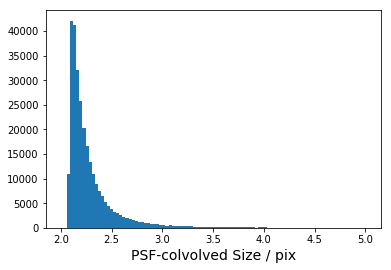

In [54]:
n, bins, patches = plt.hist(un_matched['size_pix_eff_bl'], bins=np.linspace(2,5,100))
plt.xlabel('PSF-colvolved Size / pix', fontsize=14)
plt.show()

In [55]:
print(len(un_matched), '+', len(match), '=', len(truth))

282740 + 59268 = 340095


# second round match for un-recognized blends

In [56]:
coord1 = np.asarray([gals['ra'], gals['dec']])
coord2 = np.asarray([un_matched['ra_bl'], un_matched['dec_bl']])

## make tree with cat2 to search in cat2
kdt = spatial.cKDTree(coord2.T)

## search in tree the closest to objects
## idx, d2d has the same length of the object catalog
d2d, idx = kdt.query(coord1.T)

pbl = un_matched[idx]  ## potential blends
pbl['obj_id'] = gals['obj_id']

match = join(match, pbl, keys='obj_id', join_type='left')

for col in pbl.columns:
    match[col].fill_value = -1

## match using KDtree (distance and magnitude cut)

In [57]:
## find distance cut
eps = 1./3600
rad_mask = d2d < eps

## find magnitude cut
mag_diff =  match['mag_i_cModel'] - match['mag_i'].filled()
mag_mask = np.abs(mag_diff) < 2

kd_mask = rad_mask * mag_mask * match['PM_FLAG']
pure_mask = ~kd_mask

blends_kd = match[kd_mask]
pure_kd = match[pure_mask]

print(len(blends_kd), len(pure_kd), len(match))

8013 51255 59268


## match using Ellipse Matching (and magnitude cut)

In [58]:
match['BL_FLAG'] = False

N = len(match)
for i in range(N):
    p1 = [ match[f'{X}osf'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    p2 = [ pbl[f'{X}ts_bl'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    if (match['PM_FLAG'][i] and is_overlapping(p1, p2)):   ## if has primary match, and overlap with a second source
        match['BL_FLAG'][i] = True

match['BL_FLAG'] *= mag_mask

blends = match[ match['BL_FLAG'] ]
pure = match[ ~match['BL_FLAG'] ]

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-sc

In [59]:
print(len(blends), len(pure), len(match))

8465 50803 59268


In [80]:
blends_patch = blends[ blends['patch'] == pat ]

N = len(blends_patch)

a_pix_eff = blends_patch['size_pix_eff']
b_pix_eff = blends_patch['size_minor_pix_eff']

a_pix_eff_bl = blends_patch['size_pix_eff_bl']
b_pix_eff_bl = blends_patch['size_minor_pix_eff_bl']

theta = blends_patch['theta_true']
theta_bl = blends_patch['theta_true']

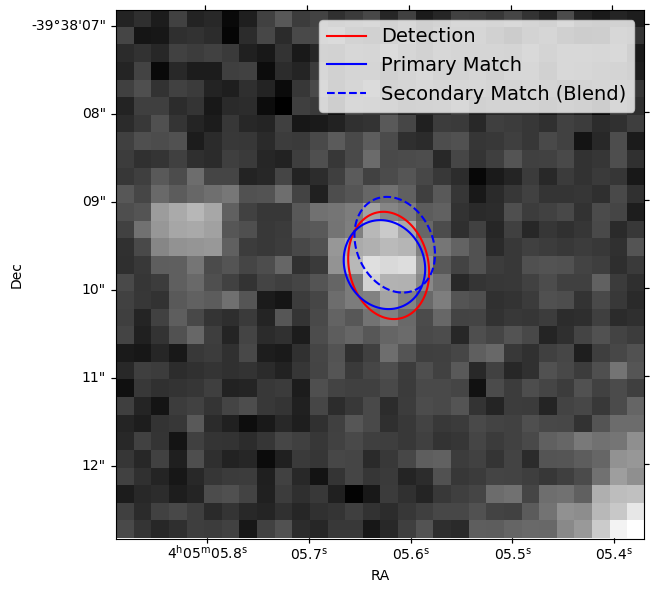

In [84]:
n = 1.5

for i in np.random.randint(0, high=N, size=1):
    
    radec = lsst.geom.SpherePoint(blends_patch["ra"][i], blends_patch["dec"][i], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    
    if np.floor(center.x) - np.round(center.x) == 0:
        pix_center_x = center.x
    else:
        pix_center_x = center.x + 1
        
    if np.floor(center.y) - np.round(center.y) == 0:
        pix_center_y = center.y
    else:
        pix_center_y = center.y + 1
        
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((pix_center_x - cutout_size*0.5, pix_center_y - cutout_size*0.5)), cutout_extent)
    
    radec_pm = lsst.geom.SpherePoint(blends_patch["ra_true"][i], blends_patch["dec_true"][i], lsst.geom.degrees)
    center_pm = skymap.findTract(radec).getWcs().skyToPixel(radec_pm)
    dx_pm = center_pm.x - center.x
    dy_pm = center_pm.y - center.y
    
    radec_bl = lsst.geom.SpherePoint(blends_patch["ra_bl"][i], blends_patch["dec_bl"][i], lsst.geom.degrees)
    center_bl = skymap.findTract(radec).getWcs().skyToPixel(radec_bl)
    dx_bl = center_bl.x - center.x
    dy_bl = center_bl.y - center.y
    
    
    cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)
    wcs = cutout.getWcs()

    off = lsst.geom.Extent2D(-(center.x - cutout_size*0.5), -(center.y - cutout_size*0.5))
    wcs_new = wcs.copyAtShiftedPixelOrigin(off)
    wcs_fits_meta = wcs_new.getFitsMetadata()
    
    image_arr = cutout.getMaskedImage().getImage().array
    
    fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(7, 7), dpi=100)

    #vmin, vmax = ZScaleInterval().get_limits(image_arr)
    vmin, vmax = image_arr.min(), image_arr.max()
    
    ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')

    rough_size = 2 * np.sqrt( blends_patch['pi_ab'][i] )
       
    params = ab2AB(n*blends_patch['a_obj'][i], n*blends_patch['b_obj'][i], blends_patch['theta_obj'][i], cutout_size/2, cutout_size/2)
    plot_shape(cutout_size/2, cutout_size/2, rough_size, params, c='r', ls='-', ax=ax)
    
    params = ab2AB(a_pix_eff[i], b_pix_eff[i], theta[i], cutout_size/2 + dx_pm, cutout_size/2 + dy_pm)
    plot_shape(cutout_size/2 + dx_pm, cutout_size/2 + dy_pm, rough_size, params, c='b', ls='-', ax=ax)
    
    params = ab2AB(a_pix_eff_bl[i], b_pix_eff_bl[i], theta_bl[i], cutout_size/2 + dx_bl, cutout_size/2 + dy_bl)
    plot_shape(cutout_size/2 + dx_bl, cutout_size/2 + dy_bl, rough_size, params, c='b', ls='--', ax=ax)
 
    ax.plot([], [], 'r-', label='Detection')
    ax.plot([], [], 'b-', label='Primary Match')
    ax.plot([], [], 'b--', label='Secondary Match (Blend)')

    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    
    ax.legend(prop={'size':14})
    
    #plt.savefig(f'blends/{i}.jpeg')
    #plt.cla()

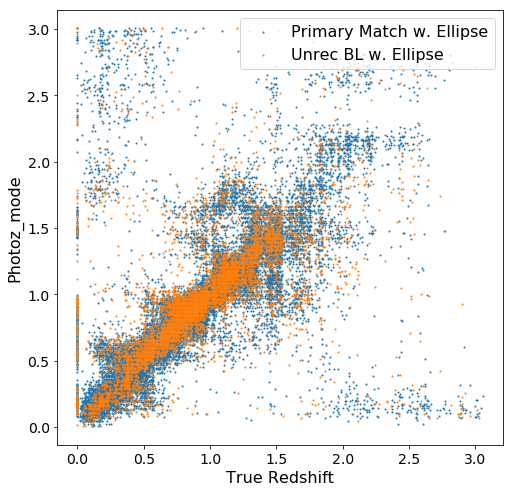

In [62]:
plt.figure(figsize=(8, 8))
plt.scatter(pure['redshift'], pure['photoz_mode'], s=1, label='Primary Match w. Ellipse')
plt.scatter(blends['redshift'], blends['photoz_mode'], s=1, label='Unrec BL w. Ellipse')

plt.xlabel('True Redshift', fontsize=16)
plt.ylabel('Photoz_mode', fontsize=16)
plt.axis('equal')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size':16})
#plt.savefig('zzf.png')

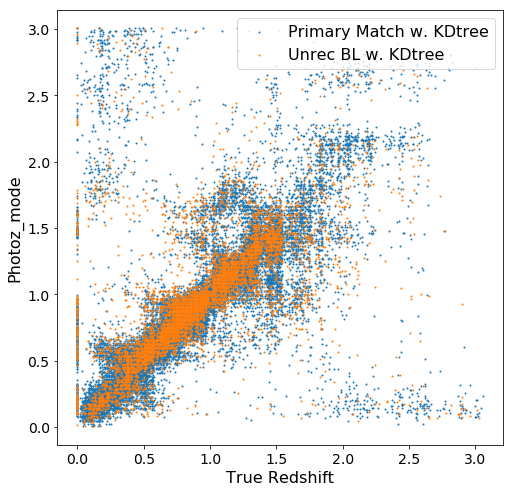

In [63]:
plt.figure(figsize=(8, 8))
plt.scatter(pure_kd['redshift'], pure_kd['photoz_mode'], s=1, label='Primary Match w. KDtree')
plt.scatter(blends_kd['redshift'], blends_kd['photoz_mode'], s=1, label='Unrec BL w. KDtree')

plt.xlabel('True Redshift', fontsize=16)
plt.ylabel('Photoz_mode', fontsize=16)
plt.axis('equal')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size':16})
#plt.savefig('zzf.png')

In [64]:
hist_kd = np.abs(blends_kd['photoz_mode'] - blends_kd['redshift']) / (1 + blends_kd['redshift'])
hist = np.abs(blends['photoz_mode'] - blends['redshift']) / (1 + blends['redshift'])

In [65]:
print(np.sum(hist_kd>0.15), np.sum(hist>0.15))
print(len(hist_kd), len(hist))
print(np.sum(hist_kd>0.15)/len(hist_kd), np.sum(hist>0.15)/len(hist))

1484 1573
8013 8465
0.18519905154124547 0.18582398109864146


In [66]:
hist_kd = np.abs(pure_kd['photoz_mode'] - pure_kd['redshift']) / (1 + pure_kd['redshift'])
hist = np.abs(pure['photoz_mode'] - pure['redshift']) / (1 + pure['redshift'])

In [67]:
print(np.sum(hist_kd>0.15), np.sum(hist>0.15))
print(len(hist_kd), len(hist))
print(np.sum(hist_kd>0.15)/len(hist_kd), np.sum(hist>0.15)/len(hist))

4478 4389
51255 50803
0.08736708613793777 0.08639253587386572


## in the KD-bl sample, not in ellipse-bl sample

In [68]:
ids = Table({'obj_id': list( set(blends_kd['obj_id']) - set(blends['obj_id']))})                      
extra_bl = join(blends_kd, ids, keys='obj_id', join_type='inner')

hist_extra_bl = np.abs(extra_bl['photoz_mode'] - extra_bl['redshift']) / (1 + extra_bl['redshift'])
print(np.sum(hist_extra_bl>0.15))
print(len(extra_bl))
print(np.sum(hist_extra_bl>0.15)/len(extra_bl))

45
260
0.17307692307692307


In [89]:
blends_patch = extra_bl[ extra_bl['patch'] == pat ]

N = len(blends_patch)

a_pix_eff = blends_patch['size_pix_eff']
b_pix_eff = blends_patch['size_minor_pix_eff']

a_pix_eff_bl = blends_patch['size_pix_eff_bl']
b_pix_eff_bl = blends_patch['size_minor_pix_eff_bl']

theta = blends_patch['theta_true']
theta_bl = blends_patch['theta_true']

print(N)

23


distance to blend: 0.4274525684156529 [arcsecs]


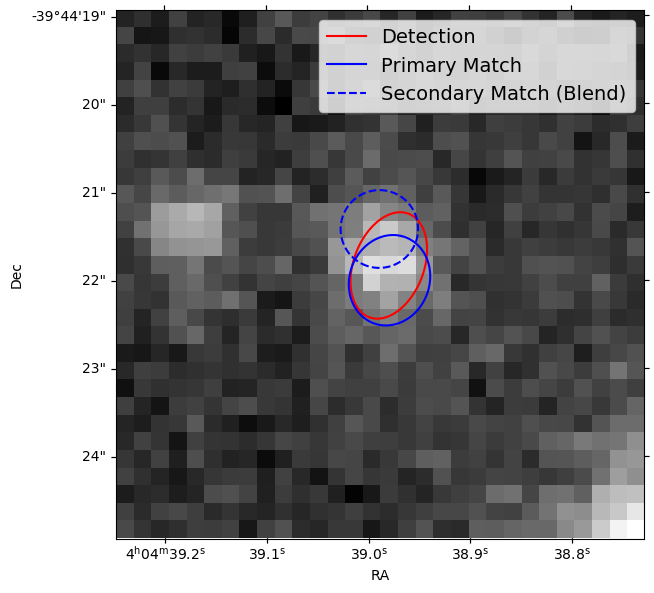

In [87]:
for i in np.random.randint(0, high=N, size=1):

    radec = lsst.geom.SpherePoint(blends_patch["ra"][i], blends_patch["dec"][i], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    
    if np.floor(center.x) - np.round(center.x) == 0:
        pix_center_x = center.x
    else:
        pix_center_x = center.x + 1
        
    if np.floor(center.y) - np.round(center.y) == 0:
        pix_center_y = center.y
    else:
        pix_center_y = center.y + 1
    
    radec_pm = lsst.geom.SpherePoint(blends_patch["ra_true"][i], blends_patch["dec_true"][i], lsst.geom.degrees)
    center_pm = skymap.findTract(radec).getWcs().skyToPixel(radec_pm)
    dx_pm = center_pm.x - center.x
    dy_pm = center_pm.y - center.y
    
    radec_bl = lsst.geom.SpherePoint(blends_patch["ra_bl"][i], blends_patch["dec_bl"][i], lsst.geom.degrees)
    center_bl = skymap.findTract(radec).getWcs().skyToPixel(radec_bl)
    dx_bl = center_bl.x - center.x
    dy_bl = center_bl.y - center.y
    
    dist = np.sqrt(dx_bl**2 + dy_bl**2)
    print('distance to blend:', dist*0.2, '[arcsecs]')
    
    
    cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)
    wcs = cutout.getWcs()

    off = lsst.geom.Extent2D(-(center.x - cutout_size*0.5), -(center.y - cutout_size*0.5))
    wcs_new = wcs.copyAtShiftedPixelOrigin(off)
    wcs_fits_meta = wcs_new.getFitsMetadata()
    
    image_arr = cutout.getMaskedImage().getImage().array
    
    fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(7, 7), dpi=100)

    #vmin, vmax = ZScaleInterval().get_limits(image_arr)
    vmin, vmax = image_arr.min(), image_arr.max()
    
    ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')

    rough_size = 2 * np.sqrt( blends_patch['pi_ab'][i] )
    
    params = ab2AB(n*blends_patch['a_obj'][i], n*blends_patch['b_obj'][i], blends_patch['theta_obj'][i], cutout_size/2, cutout_size/2)
    plot_shape(cutout_size/2, cutout_size/2, rough_size, params, c='r', ls='-', ax=ax)
    
    params = ab2AB(a_pix_eff[i], b_pix_eff[i], theta[i], cutout_size/2 + dx_pm, cutout_size/2 + dy_pm)
    plot_shape(cutout_size/2 + dx_pm, cutout_size/2 + dy_pm, rough_size, params, c='b', ls='-', ax=ax)
    
    params = ab2AB(a_pix_eff_bl[i], b_pix_eff_bl[i], theta_bl[i], cutout_size/2 + dx_bl, cutout_size/2 + dy_bl)
    plot_shape(cutout_size/2 + dx_bl, cutout_size/2 + dy_bl, rough_size, params, c='b', ls='--', ax=ax)
 
    ax.plot([], [], 'r-', label='Detection')
    ax.plot([], [], 'b-', label='Primary Match')
    ax.plot([], [], 'b--', label='Secondary Match (Blend)')

    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    
    ax.legend(prop={'size':14})
    
    #plt.savefig(f'blends/{i}.jpeg')
    #plt.cla()

22


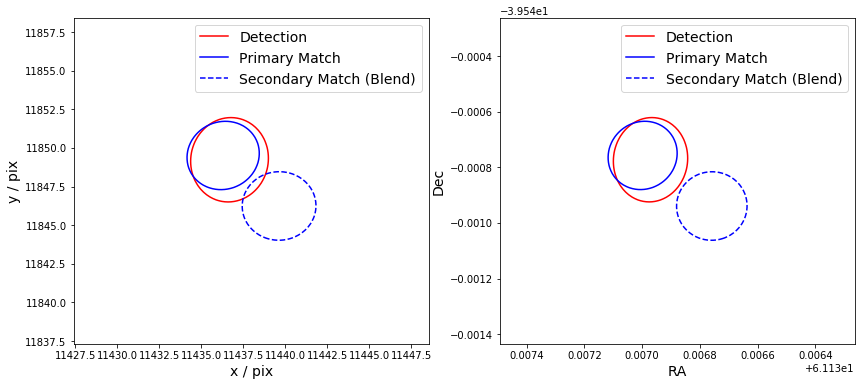

In [94]:
fig = plt.figure(figsize=(14,6))
ax2 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

for i in np.random.randint(0, high=N, size=1):


    print(i)
    ############# sky coordinates ##########
    rough_size = 3 * np.sqrt( blends_patch['pi_abs'][i] )
       
    params = [blends_patch[f'{X}osf'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    plot_shape(blends_patch['ra'][i], blends_patch['dec'][i], rough_size, params, c='r', ls='-', ax=ax1)
    
    params = [blends_patch[f'{X}ts'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    plot_shape(blends_patch['ra_true'][i], blends_patch['dec_true'][i], rough_size, params, c='b', ls='-', ax=ax1)
    
    params = [blends_patch[f'{X}ts_bl'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    plot_shape(blends_patch['ra_bl'][i], blends_patch['dec_bl'][i], rough_size, params, c='b', ls='--', ax=ax1)
    
    ax1.set_xlabel("RA", fontsize=14)
    ax1.set_ylabel("Dec", fontsize=14)
    
    ############# pixel coordinates ##########
    rough_size = 3 * np.sqrt( blends_patch['pi_ab'][i] )
       
    params = [blends_patch[f'{X}of'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    plot_shape(blends_patch['x'][i], blends_patch['y'][i], rough_size, params, c='r', ls='-', ax=ax2)
    
    params = [blends_patch[f'{X}t'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    plot_shape(blends_patch['x0_t'][i], blends_patch['y0_t'][i], rough_size, params, c='b', ls='-', ax=ax2)
    
    params = [blends_patch[f'{X}t_bl'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    plot_shape(blends_patch['x0_t_bl'][i], blends_patch['y0_t_bl'][i], rough_size, params, c='b', ls='--', ax=ax2)
    
    ax2.set_xlabel("x / pix", fontsize=14)
    ax2.set_ylabel("y / pix", fontsize=14)
    
    ax1.invert_xaxis()
 
    for ax in [ax1, ax2]:
        ax.plot([], [], 'r-', label='Detection')
        ax.plot([], [], 'b-', label='Primary Match')
        ax.plot([], [], 'b--', label='Secondary Match (Blend)')
        
        ax.legend(prop={'size':14})
    
    #plt.savefig(f'blends/{i}.jpeg')
    #plt.cla()